### Задачи к Лекции 4

__Исходные данные__ 

Дан файл **"mlbootcamp5_train.csv"**. В нем содержатся данные об опросе 70000 пациентов с целью определения наличия заболеваний сердечно-сосудистой системы (ССЗ). Данные в файле промаркированы и если у человека имееются ССЗ, то значение **cardio** будет равно 1, в противном случае - 0. Описание и значения полей представлены во второй лекции.

__Загрузка файла__

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("../data/mlbootcamp5_train.csv", 
                 sep=";", 
                 index_col="id")
# Делаем one-hot кодирование
chol = pd.get_dummies(df["cholesterol"], prefix="chol")
gluc = pd.get_dummies(df["gluc"], prefix="gluc")
df = pd.concat([df, chol, gluc], axis=1)

# Делаем пол бинарным признаком
df["gender_bin"] = df["gender"].map({1: 0, 2: 1})
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,chol_1,chol_2,chol_3,gluc_1,gluc_2,gluc_3,gender_bin
id,,,,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,1,0,0,1,0,0,1
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,0,0,1,1,0,0,0
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,0,0,1,1,0,0,0
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,1,0,0,1,0,0,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,1,0,0,1,0,0,0


## Классы в Python

Нередко, возникает необходимость создания объектов с каким-нибудь внутренним поведением и состоянием. Примерами таких объектов являются классификаторы sklearn, массивы numpy и много другое. Такой объект можно объявить с помощью ключевого слова **class**

```python
class SomeObject:
    def __init__(self, depth):
        self.a = depth
        self.target = None
        
    def fit(self, data, target):
        self.target = data
        # magic
        return 
    
    def predict(self, data):
        return self.target    
```

После этого в коде можно будет создать экземпляр данного класса
```python
a = SomeObject(depth=5)
a.fit(data, target)
a.predict(data)
```

## Задачи

**1. В sklearn на данный момент отсутствует функционал для построения деревьев решений из категориальных данных, поэтому его нужно сделать самостоятельно и проверить его работу. Что нужно сделать:**

* __создать классификатор используя только pandas, numpy и scipy. Необходимо его сделать самому, используя исключительно только numpy, pandas и scipy (запрещено использовать sklearn и прочие библиотеки). Напоминаю, что для категориальных данных операция < или > не имеют смысла (использовать только != и ==). Гиперпараметром данного классификатора должна быть максимальная глубина дерева.__
* __Проверить работу данного классификатора на наборе ("gender", "cholesterol", "gluc").__
* __С помощью кросс-валидации найти оптимальную глубину этого дерева. Для вашего классификатора GridSearchCV не подойдет, придется это сделать также самостоятельно.__
* __Нарисовать полученное дерево (я должен понять, как и откуда вы его нарисовали).__

Алгоритм работы классификатора:
 1. Перебираем все возможные признаки и смотрим либо неопределенность Джини, либо прирост информации. Это даст критерий разбиения в виде "признак == значение"
 2. Если выборка полученная при разбиении состоит из объектов одного класса (соответсвует нулевой энтропии), то данный лист просто возвращает значение этого класса.
 3. В противном случае, образуется новый узел и для него начинаем с пункта 1.
 4. Если достигли максимальной глубины, то вместа узла создаем лист, который возвращает самое вероятное значение.
 
__Замечание:__ в этой задаче не нужно использовать onehot-кодирование.

In [2]:
from sklearn.model_selection import train_test_split
data = df[["gender", "cholesterol", "gluc"]].values
#data = df[["gender", "cholesterol", "gluc", "smoke", "alco", "active"]], df['cardio']
target = df['cardio'].values
train, test, target_train, target_test = train_test_split(   
    data, target, 
    test_size=0.3)

In [108]:
class DecisionTreeC:
    """
        Бинарный классификатор на основе дерева принятия решений. 
        Работает исключительно с категориальными данными.
    """
    def __init__(self, max_depth = 5):
        self._max_depth = max_depth
        
        self._S = None       # Энтропия в узле
        self._N = None       # Число прецедентов
        self._N0 = None      # Число прецедентов с классом 0
        self._N1 = None      # Число прецедентов с классом 1
        
        # Наш вопрос, отсутствую в листе
        self._feature_idx = None     # индекс признака, который будет опрашивать
        self._feature_value = None   # значание, с которым будет сравнивать признак
        
        
        # Данные о детях, если нет, то мы в листе
        self._childrenTrue = None
        self._childrenFalse = None
        
    def setMaxDepth(self, max_depth):
        self._max_depth = max_depth
        if self._childrenTrue is not None and self._childrenFalse is not None:
            self._childrenTrue.setMaxDepth(max_depth - 1)
            self._childrenFalse.setMaxDepth(max_depth - 1)
        
    def fit(self, data, target):
        """
            Обучаем наше дерево
        """
        
        # Перевожу все в массивы numpy
        data = np.array(data)
        target = np.array(target)
        
        # Получаем информацию по классам
        self._S = self._entropy(target)
        self._N = target.shape[0]
        self._N0 = (target == 0).sum()
        self._N1 = (target == 1).sum()
        
        # Число признаков
        N_features = data.shape[1]
        
        # Максимальный прирост информации
        maxIG = None
        
        # Проходимся по всем фичам
        for feature_idx in range(N_features):
            # Формируем массив всех значений категориального признака
            feature = data[:, feature_idx]
            
            # Получаем все уникальные значения в массиве значений
            values = np.unique(feature)
            
            # Проверяем, что у нас несколько вариантов разбиений,
            # т.к. разбивать по признаку, который состоит из только одной категории
            # неинформативно
            if len(values) <= 1:
                #print(f"Feature #{feature_idx}: SKIP - ", values)
                continue
            else:
                #print(f"Feature #{feature_idx}")
                pass
            
            # Идем по всем значениям признака и для каждого расчитываем 
            # прирост информации
            for v in values:
                ig = self._ig(v, feature, target)
                
                # Если прирост больше, чем у нас уже был, то сохраняем
                # данные о вопросе
                if maxIG is None or ig > maxIG:
                    maxIG = ig
                    self._feature_idx = feature_idx
                    self._feature_value = v
                    
                #print(f"\tValue = {v:5}. IG = {ig}")
                
        # Если мы, таки, не смогли задать вопрос, то мы в листе
        if maxIG is None:
            return
        
        
        # А вот тут начинается магия. Нужно обратить внимание на то, что
        # Каждый узел дерева - это тоже дерево, так что мы для дальнейших 
        # Расчетов можем использовать наш класс дерева, но при этом
        # будем уменьшать максимальную допустимую глубину дерева на 1
        
        mask = data[:, self._feature_idx] == self._feature_value
        not_mask = np.logical_not(mask)
        
        self._childrenTrue = DecisionTreeC(self._max_depth - 1)
        self._childrenTrue.fit(data[mask], target[mask])
        self._childrenFalse = DecisionTreeC(self._max_depth - 1)
        self._childrenFalse.fit(data[not_mask], target[not_mask])
        
        # И мы получили то, что деревья будут создавать деревья, пока
        # это возможно.
                

    def _ig(self, value, arr, target):
        """
            Расчет прироста информации при разбиении: "(arr == value)?"
            Просто разделяет массив arr на две подгруппы согласно value.
            
            arr - одномерный массив всех значений категориального признака
            target - вектор целевых исходов
        """
        
        # Маски для получения подгрупп
        maskTrue = arr == value
        maskFalse = arr != value
        
        # Размеры группы и подгрупп
        N = arr.shape[0]
        NTrue = maskTrue.sum()
        NFalse = maskFalse.sum()
        
        # Энтропия группы
        S0 = self._entropy(target)
        
        # Энтропия подгрупп
        STrue = self._entropy(target[maskTrue])
        SFalse = self._entropy(target[maskFalse])
        
        return S0 - NFalse / N * SFalse - NTrue / N * STrue
        
    def _entropy(self, arr):
        """
            Честно расчитываем энтропию массива
        """
        N = arr.shape[0]
        
        # Смотрим уникальные значения и их количества
        values, counts = np.unique(arr, return_counts=True)
        
        # Получаем "вероятности"
        prob = counts / N
        
        result = 0
        for p in prob:
            if p == 0:
                continue
                
            result -= p * np.log(p)
            
        return result
    
    
    def _predict_proba(self, features):
        """
            Предсказывает вероятности для одного прецедента
        """
        
        # Если мы в листе или на максимальной глубине, то честно говорим ответ
        if self._childrenTrue is None or self._childrenFalse is None or self._max_depth <= 0:
            return self._N0 / self._N, self._N1 / self._N
             
        # В противном случае, задаем вопрос и действуем согласно ответу
        if features[self._feature_idx] == self._feature_value:
            return self._childrenTrue._predict_proba(features)
        else:
            return self._childrenFalse._predict_proba(features)
    
    def predict_proba(self, data):
        """
            Предсказываем вероятности
        """
        data = np.array(data)
        result = np.zeros( (data.shape[0], 2) )
        for i, features in enumerate(data):
            result[i] = self._predict_proba(features)
        return result
    
    def predict(self, data):
        """
            Предсказываем классы
        """
        data = np.array(data)
        result = np.zeros( data.shape[0] )
        for i, features in enumerate(data):
            p0, p1 = self._predict_proba(features)
            result[i] = 0 if p0 >= p1 else 1
        return result
        
    def _get_dot_code(self, names, name, parent=None):
        """
            Отрисовка дерева
            
            names - имена признаков, для расшифровки
            name - имя узла (уникальное)
            parent - имя родительского узла
        """
        content = "\n"

        if self._childrenTrue is not None and self._childrenFalse is not None:
            content += '%s [label="%s == %s\\nS = %.3f\\nsamples = %d\\nprob = [%.2f, %.2f]", fillcolor="#%X"];\n' % (
                name, 
                names[self._feature_idx], self._feature_value, 
                self._S, self._N, 
                self._N0 / self._N, self._N1 / self._N,
                (0xe5813900 if self._N0 > self._N1 else 0x399de500) 
                + int(0xff * (self._N0 / self._N if self._N0 > self._N1 else self._N1 / self._N))
            )               
        else:
            content += '%s [label="S = %.3f\\nsamples = %d\\nprob = [%.2f, %.2f]", fillcolor="#%X"];\n' % (
                name, 
                self._S, self._N, 
                self._N0 / self._N, self._N1 / self._N,
                (0xe5813900 if self._N0 > self._N1 else 0x399de500) 
                + int(0xff * (self._N0 / self._N if self._N0 > self._N1 else self._N1 / self._N))
            )               
            
        if parent is not None:
            content += "%s -> %s;" % (parent, name)
            
        if self._childrenTrue is not None and self._childrenFalse is not None:
            content += self._childrenFalse._get_dot_code(names, name + "f", name)
            content += self._childrenTrue._get_dot_code(names, name + "t", name)
            
        return content
            
    def to_dot(self, filename, names):
        f = open(filename, "w")
        content = self._get_dot_code(names, "root", None)
        f.write("digraph Tree {\n")
        f.write('\tnode [shape=box, style="filled", color="black"];\n')
        f.write(content)
        f.write("}")
        f.close()
        
tree = DecisionTreeC()
tree.fit(train, target_train)

In [109]:
tree.to_dot("graph.dot", names=["gend", "chol", 'gluc'])

In [110]:
!dot -Tpng "graph.dot" -o "graph.png"

Дерево

<img src="graph.png"/>

In [111]:
%%time

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

# Просто создаю генератор фолдов
kf = KFold(n_splits=3, random_state=13)
#kf = StratifiedKFold(n_splits=3, random_state=13)

max_depth = np.arange(1, 10, 1)
acc = np.zeros(max_depth.shape)
roc = np.zeros(max_depth.shape)
f1 = np.zeros(max_depth.shape)

for train_index, test_index in kf.split(data, target):
    data_train, data_test = data[train_index], data[test_index]
    target_train, target_test = target[train_index], target[test_index]
    
    # Благодаря тому, что у меня дерево строится до максимума,
    # а предсказание происходит до указанной глубины, мне достаточно
    # создать модель 1 раз
    tree = DecisionTreeC()
    tree.fit(data_train, target_train)
    
    for i, d in enumerate(max_depth):
        tree.setMaxDepth(d)
        pv = tree.predict_proba(data_test)[:,1]
        cv = pv >= 0.5
        
        acc[i] += accuracy_score(target_test, cv)
        roc[i] += roc_auc_score(target_test, pv)
        f1[i] += f1_score(target_test, cv)

acc = acc / kf.get_n_splits()
roc = roc / kf.get_n_splits()
f1 = f1 / kf.get_n_splits()

CPU times: user 5.34 s, sys: 0 ns, total: 5.34 s
Wall time: 5.37 s


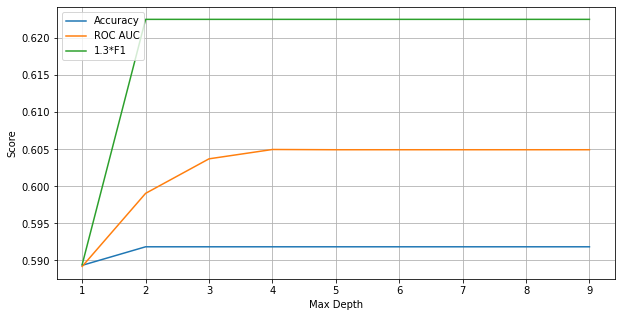

In [112]:
plt.figure(figsize=(10, 5))
plt.xlabel("Max Depth")
plt.ylabel("Score")
plt.plot(max_depth, acc, label="Accuracy")
plt.plot(max_depth, roc, label="ROC AUC")
plt.plot(max_depth, 1.3*f1, label="1.3*F1")
plt.legend()
plt.grid()
plt.show()

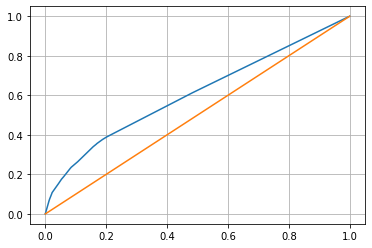

In [116]:
# Построим ROC
train, test, target_train, target_test = train_test_split(   
    data, target, 
    test_size=0.3)

tree = DecisionTreeC(5)
tree.fit(train, target_train)
prob = tree.predict_proba(test)
fpr, tpr, _ = roc_curve(target_test, prob[:, 1])
plt.plot(fpr, tpr);
plt.plot([0, 1], [0,1])
plt.grid();

**Комментарии:** Как видим, по данным признакам дерево работает не так, чтобы хорошо.

**2. В этой задаче и далее можно использовать sklearn. Выше, данные были приведены либо к бинарным признакам, либо к количественным. Это позволяет воспользоваться классификатором DecisionTreeClassifier. Нужно с помощью кросс-валидации найти оптимальный набор признаков. Показать и объяснить, как данный набор был получен.**

В данной задаче я решил сразу задачу 3.

In [117]:
def grey_code(n):
    return n ^ (n >> 1)

def to_idx(n):
    result = []
    idx = 0
    while n:
        if n % 2:
            result.append(idx)
        n = n >> 1
        idx = idx + 1
    return result

def extract(idx, data):
    """
        Формирует список полей на основе индексов, распаковывая вложеные списки
    """
    result = []
    for i in idx:        
        if isinstance(data[i], list) or isinstance(data[i], tuple):
            for f in data[i]:
                result.append(f)
        else:
            result.append(data[i])
    return result

def combinations(max_lenght):
    """
        Возвращает все доступные комбинации индексов с помощью кодов Грея
    """
    n = 1
    result = []
    while True:
        code = grey_code(n)
        idx = to_idx(code)
        if code >= (1 << max_lenght):
            break        
        result.append(idx)
        n += 1
    return result

In [124]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

features = [
    'age', 'height', 'weight', 'ap_hi', 'ap_lo', 
    'smoke', 'alco', 'active',
    'chol_1', 'chol_2', 'chol_3',
    'gluc_1', 'gluc_2', 'gluc_3', 
    'gender_bin'
]

# Сразу перебираем наилушие значения гиперпараметров
params = {
    'max_depth': np.arange(1, 15, 1),
}

tree = DecisionTreeClassifier(random_state=13)
grid = GridSearchCV(
    tree, params, scoring='accuracy',
    cv=2, refit=False,
)

comb = combinations(len(features))

In [123]:
%%time

# Все результаты буду записывать в файл, для дальнейшего анализа
# считать будет очень долго
with open("feature_selection_acc.txt", "w") as f:
    for i, cc in enumerate(comb):
        feature_comb = extract(cc, features)
        a = grid.fit(df[feature_comb], df['cardio'])

        print("=>", "[%d/%d]\t" % (i+1, len(comb)), feature_comb)    

        record = [grid.best_score_, feature_comb, grid.best_params_]        
        print(record, file=f)
        f.flush()

=> [1/32767]	 ['age']
CPU times: user 1.24 s, sys: 8.06 ms, total: 1.25 s
Wall time: 1.27 s


Cчитать будет очень долго, но если потом посмотреть на признаки, то можно увидеть, что если посмотреть на топ лучших наборов, то везде будет фигурировать признак **age**, **ap_hi**, **chol_X**, далее нередко будет встречаться **height** и некоторые категориальные признаки. Таким образом, возраст, верхнее давление и уровень холестирина являтся самыми основными признаками, остальные дают лишь незначительный вклад в улучшение качества работы классификатора.

Имеется более "оптимальный" подход, мы можем добавлять признаки по одному, выбирая самый лучший при каждом добавлении. Это даст нам "жадный" алгоритм нахождения оптимального набора признаков.

In [125]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

features = [
    'age', 'height', 'weight', 'ap_hi', 'ap_lo', 
    'smoke', 'alco', 'active',
    'chol_1', 'chol_2', 'chol_3',
    'gluc_1', 'gluc_2', 'gluc_3', 
    'gender_bin'
]

params = {
    'max_depth': np.arange(1, 15, 1),
}

tree = DecisionTreeClassifier(random_state=13)
grid = GridSearchCV(
    tree, params, scoring='accuracy',
    cv=3, refit=False,
)

# Последнее лучшая подсчитанная метрика
last_score = 0
best_features = []
best_params = None
while True:
    next_feature = None
    for feature in features:
        current_features = best_features + [feature,]
        result = grid.fit(df[current_features].values, df['cardio'].values)
        
        # Сохраням, если результат лучше, чем был
        if last_score < grid.best_score_:
            print("=>", "%s = (%s | %s)\t" % (current_features, grid.best_score_, grid.best_params_))
            next_feature = feature 
            last_score = grid.best_score_
            best_params = grid.best_params_
    
    if next_feature is None:
        break
    i = features.index(next_feature)
    best_features.append(features[i])
    del features[i]

=> ['age'] = (0.597414273509323 | {'max_depth': 1})	
=> ['ap_hi'] = (0.7144142833528558 | {'max_depth': 5})	
=> ['ap_hi', 'age'] = (0.7215143033554682 | {'max_depth': 4})	
=> ['ap_hi', 'chol_3'] = (0.7261285631536402 | {'max_depth': 5})	
=> ['ap_hi', 'chol_3', 'age'] = (0.7288571649910541 | {'max_depth': 4})	
=> ['ap_hi', 'chol_3', 'age', 'weight'] = (0.7299000198894711 | {'max_depth': 5})	
=> ['ap_hi', 'chol_3', 'age', 'ap_lo'] = (0.7302142721349753 | {'max_depth': 5})	
=> ['ap_hi', 'chol_3', 'age', 'ap_lo', 'weight'] = (0.7309857141759141 | {'max_depth': 5})	
=> ['ap_hi', 'chol_3', 'age', 'ap_lo', 'weight', 'smoke'] = (0.7310000000942845 | {'max_depth': 5})	
=> ['ap_hi', 'chol_3', 'age', 'ap_lo', 'weight', 'gluc_1'] = (0.731771425604847 | {'max_depth': 5})	
=> ['ap_hi', 'chol_3', 'age', 'ap_lo', 'weight', 'gluc_1', 'smoke'] = (0.7317857115232173 | {'max_depth': 5})	
=> ['ap_hi', 'chol_3', 'age', 'ap_lo', 'weight', 'gluc_1', 'smoke', 'chol_1'] = (0.7317999968293515 | {'max_depth': 5})

Здесь можно увидеть практически тот же набор значений, но считать будет значительно быстрее.

**3. Для набора признаков полученных в задаче 3, с помощью кросс-валидации найти оптимальный набор гиперпараметров.**

См. задачу 2.

**Комментарии:** Ваши комментарии здесь.

**4. Сравнить с помощью кросс-валидации классификатор "наивный байес" и "решающее дерево" на количественных признаках. Показать, какой из них лучше.**

In [126]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

data= df[['age','height','weight', 'ap_hi', 'ap_lo']].values
target = df['cardio'].values

classifiers = [("Tree(depth=%d)" % i, DecisionTreeClassifier(max_depth=i, random_state=13)) for i in range(1, 15)]
classifiers.append(("GaussianNB()", GaussianNB()))

results = []
for name, classifier in classifiers:
    cv = cross_validate(classifier, data, target, cv=3, scoring=['accuracy', 'f1', 'roc_auc'])
    results.append((name, cv["test_f1"].mean(), cv["test_accuracy"].mean(), cv["test_roc_auc"].mean()))

dr = pd.DataFrame(results, columns=["Name", "F1", "Accuracy", "ROC AUC"])
print("ROC_AUC\n", dr.sort_values(by="ROC AUC")[-1:])
print()
print("Accuracy\n", dr.sort_values(by="Accuracy")[-1:])
print()
print("F1\n", dr.sort_values(by="F1")[-1:])
print()

dr

ROC_AUC
             Name        F1  Accuracy   ROC AUC
5  Tree(depth=6)  0.710576  0.720014  0.785513

Accuracy
             Name        F1  Accuracy   ROC AUC
4  Tree(depth=5)  0.713556    0.7224  0.784793

F1
             Name       F1  Accuracy   ROC AUC
3  Tree(depth=4)  0.71472  0.720943  0.781979



,Name,F1,Accuracy,ROC AUC
0,Tree(depth=1),0.685330,0.713843,0.713789
1,Tree(depth=2),0.685330,0.713843,0.765402
2,Tree(depth=3),0.712775,0.721214,0.777331
3,Tree(depth=4),0.714720,0.720943,0.781979
4,Tree(depth=5),0.713556,0.722400,0.784793
5,Tree(depth=6),0.710576,0.720014,0.785513
6,Tree(depth=7),0.707737,0.720571,0.784054
7,Tree(depth=8),0.708751,0.719071,0.781009
8,Tree(depth=9),0.704379,0.718471,0.777205
9,Tree(depth=10),0.703627,0.715571,0.770643


**Комментарии:** По всем метрикам, выйграло решающее дерево.